## Why Areas of Interest (AOI)?
Eye Tracking Data is often analysed with respect to **Areas of Interest** - AOIs.
AOIs define regions in the visual scenery that are of particular relevance for the researcher, such as a specific product, an image or a face.

The AOI is drawn around that region, mostly as a simple geometrical shape, like a rectangle or a circle. When analysing the gaze data, we can then ask questions like:
- **How often** did a participant look at the region of interest?
- **How long** did a participant look at the region of interest?
- In which **order** did the participant look at different regions of interest?

We can then use this data to compare different regions of interest, asking for example:
- Which region was most often looked at?
- Which region was looked at the longest?
- Which region was first looked at?

From these information, we can then make inference on properties like the salience, visiblity or attractiveness of the objects in the regions of interest from the perspective of the particpant.

Traditionally, eye tracking research has focussed on AOIs in static scenes - e.g. showing a picture on a computer screen and measuring where people look on the screen while the head and the body is mostly fixed - only the eyes move.

With mobile eye trackers, we can analyse gaze position on AOIs in dynamic scenes, when people move around in an evironment, constantly changing their body and head position. 


## AOIs with the Reference Image Mapper
You can think about the difference between a static and a dynamic scene in analogy to the difference between a photo camera and a video camera. In the static case, the scene is like a photo - what you can see on it never changes. In the dynamic case, the scene is a video - it changes in every instant. **Pupil Invsible Glasses** record this video with the world camera.

A dynamically changing scene poses some serious challenges to gaze tracking. To make this simpler, you can use the **Reference Image Mapper**. This enrichment takes the gaze position along with the video from the world camera, and projects them onto a **reference image**. You can think of the reference image mapper as a converter from video to photo.

The reference image mapper, however, has an important limitation: in the same way as it is impossible to show every room and wall in a house with one single photo, you cannot use one single reference image when the scencery is changing a lot. So when analysing AOIs with the Reference Image Mapper, you might either find that the scene is mostly static, and one reference image is suffcient to capture all your AOIs, or that the scene is mostly dynamic, such that your AOIs don't fit into a single photo.

In this example, we want to show you how to run AOI anlysis in both cases. We will use a hands-on example from a dataset, we collected in an art gallery.


## AOIs in an Art Gallery
Imagine, you'd be interested in characterizing human gaze behaviour as people look at different paintings in a gallery and you are wondering:
- Which painting was most often looked at?
- Which painting was looked at the longest?
- Which painting was looked at first?

Since you are interested in the painting as a whole, not in it's individual features (yet), you can define each painting as an AOI. 

In a gallery, we encounter different types of art display:
- Walls with many images, where the visitor can stand in front of the wall and look at many different paintings, without moving too much.
- Walls with individual images, where the visitor needs to move from wall to wall and from room to room in order to look at all paintings.

In the first case, you are dealing with a **static scene**. You can use a single reference image that shows the entire wall with all it's paintings. The reference image mapper will take care the head motion of the participant.

In the second case, you ar dealing with a **dynamic scene**. You will need multiple reference images, as the paintings are distributed across several rooms. The reference image mapper automatically detects when the paintings you are interested in come into the world camera's field of view and handles the movement in the vicinity of each painting.

##### Enough talking, let's dive into the notebook.

## Setup and Imports
First, we load the libraries we need to run our anaysis

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import pathlib
import seaborn as sns

from demo_utils import extract_gaze_for_events
from PIL import Image
from sklearn.linear_model import LinearRegression

# PupilLabs Reference Image Mapper for AOIs in static scenes

## Step 1: Load the data
After recording your data and downloading the reference image mapper enrichment from pupil cloud, you find all the needed data in a single folder.

In [2]:
# point the program to the folder with the data
static_path = "./reference_export/standing/Art-_Gallery_Picture_Viewing_REFERENCE-IMAGE-MAPPER_multiple_paintings_standing_csv"

# make sure the directory exists
assert os.path.isdir(static_path), "This directory doesn't exist."

# check the files in the folder
os.listdir(static_path)

['gaze.csv',
 'enrichment_info.txt',
 'reference_image.jpeg',
 'sections.csv',
 'fixations.csv']

We have 5 different files that contain different types of data. The exact content of these files is listed here: https://docs.pupil-labs.com/cloud/enrichments/#export-format-2 

First, we want to take a look at our reference image, making sure it looks as expected.

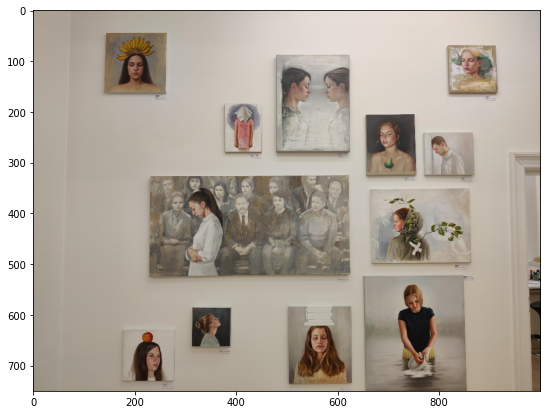

In [3]:
static_fig, static_axs = plt.subplots(1,1, figsize = (10,7))
scaling_factor = 0.25
reference_image = cv2.imread(f"{static_path}/reference_image.jpeg")
reference_image = cv2.cvtColor(reference_image, cv2.COLOR_BGR2RGB)
fullsize_image = reference_image.copy()
reference_image = cv2.resize(reference_image, dsize = None, fx = scaling_factor, fy = scaling_factor)
# convert color format to RGB


static_axs.imshow(reference_image);

## Step 2: Defining where the AOIs are located in the reference image
There are 12 paintings in this one reference image - that is 12 different AOIs. In order to analyse these, we need to mark them all, by defining their location on this image.

We use the cv2 library for that task. The next cell will open a window in which you can mark the AOIs by clicking and dragging a rectangle around them. If you are happy with the selection of one AOI, hit "enter" or "space". You won't notice a change on the image. Don't worry, your marked area will be saved! If you want to cancel a drawing, press "c" or simply start a new drawing. Once you marked all AOIs, hit "esc".

In [4]:
static_aois = cv2.selectROIs("AOI Annotation", reference_image);
cv2.destroyAllWindows();

print(static_aois)

[[135  41 133 130]
 [375 183  78  98]
 [478  89 147 193]
 [656 204  97 122]
 [817  66  99 102]
 [769 239 101  87]
 [226 322 400 204]
 [666 348 193 156]
 [172 628 110 103]
 [313 583  78  79]
 [502 581 127 158]
 [647 523 209 227]]


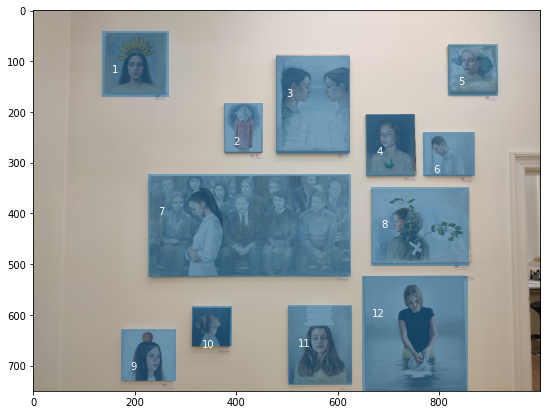

In [5]:
# plot the reference image and overlay the AOIS
fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.imshow(np.asarray(reference_image))

for idx, aoi in enumerate(static_aois):
    ax.add_patch(patches.Rectangle(aoi, *aoi[2:], alpha=0.5))
    ax.text(aoi[0] + 20, aoi[1] + 80, f"{idx + 1}", color="white")
ax.grid(False)

You can adjust the position of the aois by changing the entries in the array.

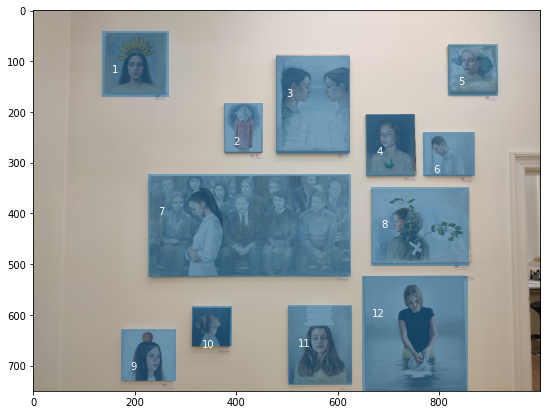

In [6]:
# Define AOIs
static_aois[8] += [0, 0, 0, 0] 
# List the painting ids as names 
static_paintings = [idx + 1 for idx in range(len(static_aois))]

# plot the reference image and overlay the AOIS
fig, ax = plt.subplots(1,1, figsize = (10,7))
ax.imshow(np.asarray(reference_image))
for idx, aoi in enumerate(static_aois):
    ax.add_patch(patches.Rectangle(aoi, *aoi[2:], alpha=0.5))
    ax.text(aoi[0] + 20, aoi[1] + 80, f"{idx + 1}", color="white")
ax.grid(False)

We now have a list of all our AOIs - which are conveniently inside one reference image. We know the position of all AOIs relative to each other. Now we can start visualizing the eye movement data.

In [7]:
# Loading data files
static_fixations = pd.read_csv(f"{static_path}/fixations.csv")
static_sections = pd.read_csv(f"{static_path}/sections.csv")

# split the data into individual recording sections:
fixations_by_recording = list(extract_gaze_for_events(static_fixations, static_sections, column_timestamps = 'start timestamp [ns]'))

## Step 3: Scan Path
The most common visualization for gaze in a static scene is a **scan path**. Scan paths draw lines between individual fixations and thus show in which order a scene was explored. 

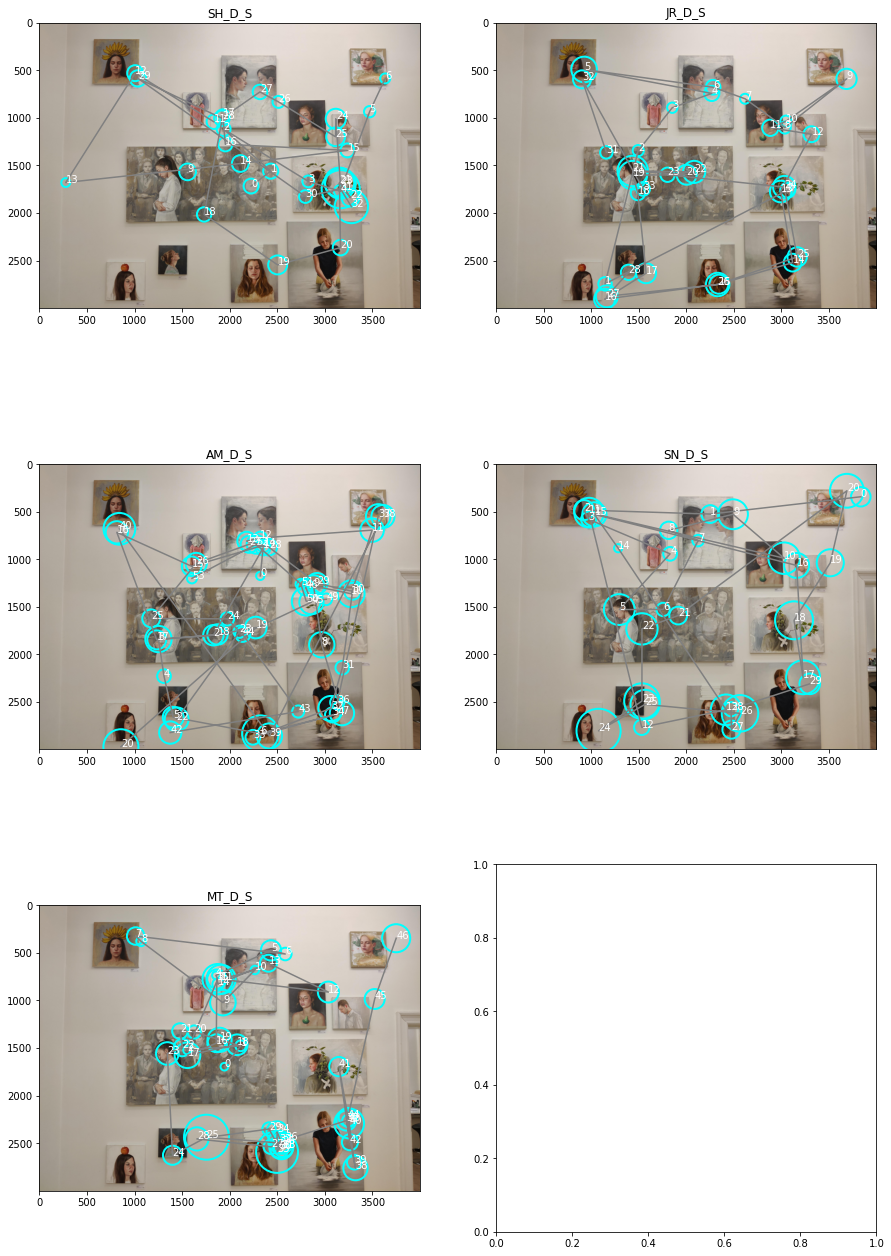

In [8]:
# initialize the figure
n_participants = len(fixations_by_recording)
fig_static_fixations, ax_static_fixations = plt.subplots(int(np.ceil(n_participants/2)),2, figsize=(15, 23))


# this function return the x and y position of the gaze
def get_gaze_position(recording, x_position_column, y_position_column, duration_column):
    # filter the data that belongs to this id
    recorded_gaze = recording[1]
    # extract x and y coordniates
    recorded_x = recorded_gaze[x_position_column]
    recorded_y = recorded_gaze[y_position_column]
    duration = recorded_gaze[duration_column]
    name = recording[0]['recording name']
    
    return recorded_x, recorded_y, duration, name


for ax, rec in zip(ax_static_fixations.flatten(), fixations_by_recording):
    ax.imshow(np.asarray(fullsize_image))
    x, y, duration, name = get_gaze_position(rec, 'fixation x [px]', 'fixation y [px]', 'duration [ms]')
    ax.scatter(x.values, y.values, marker='o', facecolor='none', edgecolor = 'cyan', linewidth = 2, s = duration.values)
    for i in range(len(x)):
        ax.annotate(i, (x.values[i], y.values[i]), color = 'white')
    ax.plot(x.values,y.values, color = 'grey')
    ax.set_title(name)

## Step 4: Detecting fixations inside AOIs

We can now check which paintings where fixated and which were not.
To do that, we want to check if the fixations fell inside our AOIs

In [9]:
# scale the AOIs to the full image
static_scaled_aois = static_aois / scaling_factor

In [10]:
def check_in_rect(fixations, rectangle):
    
    rect_x, rect_y, rect_width, rect_height = rectangle
        
    x_hit = fixations['fixation x [px]'].between(rect_x, rect_x+rect_width) 
    y_hit = fixations['fixation y [px]'].between(rect_y, rect_y+rect_height)
    
    in_rect_idx = x_hit & y_hit
    
    return(in_rect_idx)
        
static_fixations['AOI'] = None

for aoi_id, aoi in enumerate(static_scaled_aois):
    static_fixations.loc[check_in_rect(static_fixations, aoi), 'AOI'] = static_paintings[aoi_id]

static_fixations['recording name'] = static_fixations['recording id'].replace(static_sections['recording id'].values, static_sections['recording name'].values)
static_fixations.head()

,section id,recording id,fixation id,start timestamp [ns],end timestamp [ns],duration [ms],fixation detected in reference image,fixation x [px],fixation y [px],AOI,recording name
0,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,248,1636035560036503914,1636035560228482914,191,True,2410.0,2134.0,None,SH_D_S
1,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,249,1636035560256651914,1636035560476503914,219,True,2224.0,1717.0,7,SH_D_S
2,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,250,1636035560500491914,1636035560728557914,228,True,2431.0,1560.0,7,SH_D_S
3,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,251,1636035560776494914,1636035560968578914,192,True,1936.0,1118.0,3,SH_D_S
4,055f4166-0c12-4752-b1a6-32c94b1c56b2,54a0dfa4-23dd-48f4-806e-6fdb519d6a7c,252,1636035561008557914,1636035561148511914,139,True,2826.0,1668.0,8,SH_D_S


You can now see the new columns "AOI" - this column contains the information if the gaze fell inside a given area of interest. E.g. Fixation 249 (the second entry) was made on AOI 7.

## Step 5: Extracting Metrics

With this information, we can now compute some metrics of the gaze position on the paintings.

### AOI Hits
We compute the 'hit' rate by checking a given AOI was looked at at least once by a participant.

In [11]:
static_observers = static_sections['recording name']

# first, we extract the hit count
static_fixation_counts = static_fixations.pivot_table(index='recording name', 
                      columns = 'AOI',
                      values='fixation id',
                      fill_value=0, 
                      aggfunc='count').unstack().to_frame().rename(columns={0:'fixation count'})
static_fixation_counts.reset_index(inplace = True)

# and boil it down to yes/no
static_hits = static_fixation_counts.copy()
static_hits['hit'] = static_hits['fixation count']>0

static_hits.head()

,AOI,recording name,fixation count,hit
0,1,AM_D_S,1,True
1,1,JR_D_S,2,True
2,1,MT_D_S,2,True
3,1,SH_D_S,2,True
4,1,SN_D_S,4,True


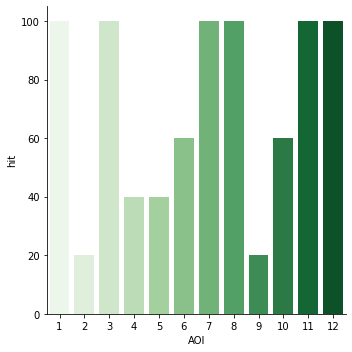

In [12]:
# Get the mean hit rate over observers and plot
static_proportional_hits = static_hits.groupby('AOI').mean().reset_index()
static_proportional_hits.loc[:,'hit'] =  static_proportional_hits['hit']*100

sns.catplot(x="AOI", y="hit", kind="bar", data=static_proportional_hits, palette = "Greens");

Some AOIs (3,6,7,11 & 12) were looked at by all observers. Others (2,4,5 & 9) were more often missed.

##### rcd note: AOI Labels reflectining picture/artist names in Cloud project 
##### Clara comment: The full wall only had the label "mulitple pictures" - we still need to look up the names of the artist/image

The AOIs were looked at for a different duration. But what does that mean? We need te be carefull when interpreting these infomation, because there are several factors that can make an image more likely to be looked at. 

For example - the larger the image, the more likely people are to look at it. 
We can show the relationship between image size and hit rates in a scatter plot:

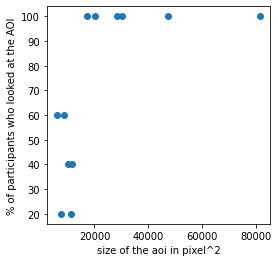

In [34]:
# compute the size of the AOI by multiplying width and length of the AOIS
aoi_size = np.array([AOI[2] * AOI[3] for AOI in static_aois])

size_hits_fig, size_hits_ax = plt.subplots(1,1, figsize=(4,4))
size_hits_ax.scatter(aoi_size, static_proportional_hits['hit'])

size_hits_ax.set_xlabel('size of the aoi in pixel^2')
size_hits_ax.set_ylabel('% of participants who looked at the AOI');

Images larger than 20000 pixel^2 were looked at by all participants.

### Time to First Fixation
Time to first fixation measures how long it takes an observer to look at a given AOI for the first time. Observers started walking around in the gallery at different times. The absolute timestamps reflect that difference. To make the timestamps comparable across subjects, we will align an observer's fixations to the time this observer made their first fixation.

In [ ]:
static_fixations['aligned timestamp [s]'] = None

for observer in static_observers:
    obs_idx = static_fixations[static_fixations['recording name'] == observer].index
    section_start_time = static_sections.loc[static_sections['recording name'] == observer, 'section start time [ns]'].values
    static_fixations.loc[obs_idx, 'aligned timestamp [s]'] = (static_fixations.loc[obs_idx, 'start timestamp [ns]'] - section_start_time)/1e9 

In [ ]:
static_first_contact = pd.DataFrame(static_fixations.groupby(['recording name', 'AOI']).min()['aligned timestamp [s]'])
static_first_contact.reset_index(inplace = True)

In [ ]:
# Now, we can compute the mean time to first contact
sns.catplot(x="AOI", y="aligned timestamp [s]", kind="bar", data=static_first_contact, palette = "Greens", ci = 95);

### Dwell time

Dwell time describes the total time an observer has looked at a given AOI. We can find the dwell time by summing up the durations of all fixations we detected, seperately for each AOI.

In [ ]:
# add recording name for better readablity
static_dwell = static_fixations.groupby(['recording name', 'AOI']).sum()['duration [ms]']
static_dwell = pd.DataFrame(static_dwell).sort_values('AOI')
static_dwell.reset_index(inplace = True)

In [ ]:
# plot the average time spent on each image
sns.catplot(x="AOI", y="duration [ms]", kind="bar", data=static_dwell, palette = "Greens", ci = 95);

Comparably to where most people looked, paintings 7,8,11 and 12 were also looked at the longest. What we can also see in this graph is that the measures are very variable (indicated by the error bars). The missing error bar on the second AOI indicates, that only one observer looked at this AOI.

We have looked at how we can extract AOIs in a static scene, with one reference image created by the Reference Image Mapper. We computed 3 different metrics on the gaze data: hit rate, dwell time and time to first contact.

Next, we will look at similar metrics for AOIs in dynamic scenes.

# PupilLabs Reference Image Mapper for AOIs in dynamic scenes

The biggest difference when using the Reference Image Mapper for dynamic scenes is that we will now need multiple reference images. Each reference image now represents one individual painting, so there is no more difference between the AOI and the reference images.

The gaze data is still stored in one folder per reference image - so we will end up having as many data folders as we have AOIs to analyse. While this sounds like we might have more information here that we had in the static case, we actually loose something important: the reference images don't reveal anything about their location in the art gallery. We won't know from looking at them how they were positioned relative to each other. 

Still, we can compute metrics that are comparable, or even equal to the metrics in the static case.

## Step 1: Load the data

Because we need to load the data from a bunch of different sub-folders, we create a function that loops through the files for us.

In [ ]:
dynamic_path = './reference_export/walking/'

def get_file_list(file_name, directory = dynamic_path):
    all_aoi_recordings = os.listdir(directory)
    return [f"{directory}{aoi}/{file_name}" for aoi in all_aoi_recordings]

def load_csv_files(file_name):
    
    if not '.csv' in file_name:
        file_name = file_name + '.csv'
        
    file_list = get_file_list(file_name)
    section_list = get_file_list('sections.csv')
    data = pd.DataFrame()
    
    for file, section in zip(file_list, section_list):
        
        df = pd.read_csv(file)
        sections = pd.read_csv(section)
        df['recording name'] = df['recording id'].replace(sections['recording id'].values, sections['recording name'].values)
        df['AOI'] = file.split('MAPPER_')[1].split('_walking')[0]
        
        data = pd.concat([data,df], ignore_index = True)
        
    return data

dynamic_sections = load_csv_files('sections.csv')
dynamic_gaze = load_csv_files('gaze.csv')
dynamic_fixations = load_csv_files('fixations.csv')
dynamic_fixations['AOI'] = dynamic_fixations['AOI'].replace({
    'Adel_Dauood_2': 'AD 2',
    'Adel_Dauood_3': 'AD 3',
    'Adel_Dauood_4': 'AD 4',
    'Christopher_Blanc_2': 'Blanc 2',
    'Gary_Cain' : 'Cain',
    'Gunlief_Grube': 'Grube',
    'Ingerlise_Vikne': 'Vikne',
    'Vivian_Hoi_Nielsen': 'Nielsen'
    
})

dynamic_images = get_file_list('reference_image.jpeg')
# observer ids
dynamic_observers = np.unique(dynamic_gaze['recording name'])

#### Look at the reference images

In [ ]:
# create a plot for the images
fig_reference, ax_reference = plt.subplots(int(np.ceil(len(dynamic_images)/4)),4, figsize = (25,12))

for ax, im in zip(ax_reference.flatten(),dynamic_images):
    dynamic_reference_image = Image.open(im)
    ax.imshow(np.asarray(dynamic_reference_image))
    ax.set_title(im.split('MAPPER_')[1].split('_walking')[0])

You can see how each reference image shows one paiting. That means, we can skip the steps in which we define the AOIs - they are defined by the identity of the reference image.

## Step 2: Filter the data for gaze/fixation on a reference image

The eye tracker keeps recording even when none of the paintings of interest is in sight. This results in many gaze and fixations instances that are not detected on an reference image, but somewhere in between. 

Before we want to analyse the data, we have to remove gaze samples outside of the reference imagess. The column 'gaze detected on refernence image' gives us a handy way to do so.

In [ ]:
print(f"The gaze data frame contained originally {len(dynamic_gaze)} samples.")
print(f"The fixation data frame contained originally {len(dynamic_fixations)} samples.")

# filter the data frames 
dynamic_gaze = dynamic_gaze[dynamic_gaze['gaze detected in reference image']] 
dynamic_fixations_unfiltered = dynamic_fixations.copy()
dynamic_fixations = dynamic_fixations[dynamic_fixations['fixation detected in reference image']] 

print(f"After cleaning, the gaze data frame contained {len(dynamic_gaze)} samples.")
print(f"After cleaning, the fixation data frame contained {len(dynamic_fixations)} samples.")


## Step 3: Visual Journey
Showing scanpaths between the images is not possible anymore. 

So instead of visualising how the eyes travel from image to image in space, we will show how they travel from image to image in time, using an approach we call **visual journey**. 
In the visual journey, we visualize the times when fixations were detected on any of the reference images. 

Since our participants all started their walk in the museum at different times, we will align the data to the start of the section.

In [ ]:
def align_timestamps(df, time_column, observers = dynamic_observers):
    for observer in observers:
        obs_idx = df[df['recording name'] == observer].index
        section_start_time = min(dynamic_sections[dynamic_sections['recording name'] == observer]['section start time [ns]'].values)
        df.loc[obs_idx, 'aligned timestamp [s]'] = (df.loc[obs_idx, time_column] - section_start_time)/1e9 
        
    return df['aligned timestamp [s]']

dynamic_gaze['aligned timestamp [s]'] = align_timestamps(dynamic_gaze, 'timestamp [ns]')

# next, we can plot the visual journey
sns.catplot(
    data=dynamic_gaze,
    x="aligned timestamp [s]",
    y="recording name",
    hue="AOI",
    aspect=1,
    linewidth=0,
    s=1,
    palette = 'YlGnBu'
);

## Step 4: Metrics
We can compute some metrics on this data, too.

### Reach

In [ ]:
dynamic_fixation_counts = dynamic_fixations.pivot_table(index='recording name', 
                      columns = 'AOI',
                      values='fixation id',
                      fill_value=0, 
                      aggfunc='count').unstack().to_frame().rename(columns={0:'fixation count'})
dynamic_fixation_counts.reset_index(inplace = True)

# We can generalize this plot by showing what proportion of subjects had at least on fixation of this image
dynamic_hits = dynamic_fixation_counts.copy()
dynamic_hits.loc[:,'hit'] = dynamic_hits['fixation count']>0

dynamic_reach = dynamic_hits.groupby('AOI').mean().reset_index()
dynamic_reach.loc[:,'hit'] =  dynamic_reach['hit']*100

sns.catplot(x="AOI", y="hit", kind="bar", data=dynamic_reach, palette = "Greens");

Each of our defined AOIs was looked at by all observers in the study.

### Time to first contact
Computing the time to first contact is a bit unfair in this case. The rooms were visited in a specific order that forces a temporal pattern on the order in which the imaged are seen. 

In [ ]:
dynamic_fixations['aligned timestamp [s]'] = align_timestamps(dynamic_fixations, 'start timestamp [ns]')

dynamic_first_contact = pd.DataFrame(dynamic_fixations.groupby(['recording name', 'AOI']).min()['aligned timestamp [s]'])
dynamic_first_contact.reset_index(inplace = True)

In [ ]:
# Finally, we can compute the mean time to first contact
sns.catplot(x="AOI", y="aligned timestamp [s]", kind="bar", data=dynamic_first_contact, palette = "Greens", ci = 95);

### Dwell time

In [ ]:
# add recording name for better readablity
dynamic_dwell = dynamic_fixations.groupby(['recording name', 'AOI']).sum()['duration [ms]']
dynamic_dwell = pd.DataFrame(dynamic_dwell)
dynamic_dwell.reset_index(inplace = True)

In [ ]:
sns.catplot(x="AOI", y="duration [ms]", kind="bar", data=dynamic_dwell, palette = "Greens", ci = 95);